## Loading Libs

In [2]:
import argparse
import logging
import seaborn as sns
import sys
sys.path.append("/root/Soufien/disvae")

import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'
from tqdm.notebook import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score, mean_absolute_error
import json
from timeit import default_timer as timer
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from torch.utils.data import DataLoader
from utils.datasets import DSprites
import pandas as pd
from disvae.utils.modelIO import load_model, load_metadata
logger = logging.getLogger(__name__)
dim,thresh=1,0.7
import argparse
import logging
import seaborn as sns
import sys
import os
from scipy import stats
import random
import math
import json
import matplotlib.gridspec as gridspec
from configparser import ConfigParser
import torch
from torchvision import transforms, datasets
import logging
from tqdm import tqdm

from disent.dataset import DisentDataset
from disent.metrics import utils
import numpy as np
import scipy
import scipy.stats
from scipy.stats import differential_entropy
from disent.metrics.utils import make_metric
import numpy as np
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from disvae import init_specific_model, Trainer, Evaluator
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import LOSSES, RECON_DIST, get_loss_f
from disvae.models.vae import MODELS
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from utils.helpers import (create_safe_directory, get_device, set_seed, get_n_param,
                           get_config_section, update_namespace_, FormatterNoDuplicate)
from utils.visualize import GifTraversalsTraining
import os
from sklearn.feature_selection import mutual_info_regression
from torch.utils.data import DataLoader
from utils.datasets_red import MNIST
import pandas as pd
from disvae.utils.modelIO import load_model, load_metadata
from torchvision import transforms, datasets
import torchvision
from PIL import Image
from matplotlib.patches import  Circle
from torch.utils.data import DataLoader
from disent.dataset import DisentDataset
from disent.dataset.data import XYObjectData, DSpritesData
from disent.frameworks.vae import BetaVae
from disent.model import AutoEncoder
from disent.model.ae import DecoderConv64, EncoderConv64
from disent.dataset.transform import ToImgTensorF32
from disent.util import is_test_run
from scipy.stats import entropy
from scipy import stats


## Functions to traverse the latent space and return the reconstructed images

In [4]:
def _get_traversal_range(max_traversal=0.6, mean=0, std=1):
        max_traversal = max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        return (-1 * max_traversal, max_traversal)
def decode_latents(model,code_samples):
    code_samples = code_samples.to(device)
    return model.decoder(code_samples).cpu()
def traverse_latent(data,device,model,idx,n_samples,lower_bound,upper_bound,n_cols,plot=True):

    with torch.no_grad():
        
                post_mean, post_logvar = model.encoder(data.to(device))
                samples = post_mean
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

    traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=n_samples)
    
    for i in range(n_samples):
            samples[i, idx] = traversals[i]
    latent_samples = torch.cat([samples], dim=0)
    decoded_traversal = decode_latents(model, latent_samples)
    n_imgs = decoded_traversal.shape[0]
    img_grid = []
    for img_ind in range(n_imgs):
        img_grid.append(decoded_traversal[img_ind].mul_(255).add_(0.5).clamp_(0,255).detach().numpy().reshape((64,64,1)))
    if plot:
        splitted_imgs = [img_grid[i:i+n_cols] for i in range(0, len(img_grid), n_cols)]
        cols = len(splitted_imgs[0])
        rows = len(splitted_imgs)
        plt.figure(figsize = (15,8))
        gs1 = gridspec.GridSpec(rows, cols)
        gs1.update(wspace=0.1, hspace=0.5) 
        for i in range(rows):
            for j in range(cols):
                ax1 = plt.subplot(gs1[i*rows+j])
                ax1.axis("off")
                ax1.imshow(splitted_imgs[i][j])
                #ax1.set_title("code value {}".format(round(float(traversals[i*rows+j]),3))) 
                ax1.set_xticklabels([])
                ax1.set_yticklabels([])
                ax1.set_aspect('equal')
        plt.show()    
    return img_grid


## Helper functions to measure the generative factors

In [5]:
def get_center(img):
    lower_row = 64
    for line in range(63,-1,-1):
        if np.sum(img[line,:])>0:
            lower_row = line 
            break
    higher_row = 0 
    for line in range(0,64):
        if np.sum(img[line,:])>0:
            higher_row = line 
            break 
    lower_col = 0
    for col in range(0,64):
        if np.sum(img[:,col])>0:
            lower_col = col 
            break 
    higher_col = 0
    for col in range(63,-1,-1):
        if np.sum(img[:,col])>0:
            higher_col = col 
            break   
    center = ((lower_col+higher_col)/2,(lower_row+higher_row)/2)
    contour_pts = [(lower_col,lower_row),(lower_col,higher_row),(higher_col,lower_row),(higher_col,higher_row)]
    return center,contour_pts
def get_centers_mov(variables):
    centers = []
    for i in range(len(variables)):
        img = np.reshape(variables[i],(64,64))
        if img.max()<=1:
            img = img*255
        img[img<100]=0
        center, _ = get_center(img)
        centers.append(center)
    return [(abs(centers[i][0]-centers[i-1][0]),abs(centers[i][1]-centers[i-1][1])) for i in range(1,(len(centers)))],centers   
def get_surface(img):
    return (img[img>0].shape[0]/(64*64))
def get_surface_mov(variables):
    sizes = []
    for i in range(len(variables)):
        img = np.reshape(variables[i],(64,64))
        if img.max()<=1:
            img = img*255
        img[img<100]=0
        sizes.append(get_surface(img))
    return [abs(sizes[i]-sizes[i-1]) for i in range(1,len(sizes))],sizes 
def get_angle(pts1,pts2):
    x1,y1,x2,y2 = pts1[0],pts1[1],pts2[0],pts2[1]
    if x1 != x2:
        return math.pi/2 + math.atan((y2-y1)/(x2-x1))
    return 0
def get_angles_mov(variables):
    centers = []
    contours = []
    for i in range(len(variables)):
        img = np.reshape(variables[i],(64,64))
        if img.max()<=1:
            img = img*255
        img[img<100]=0
        center, contour = get_center(img)
        contours.append(contour)
        centers.append(center)
    angles_mov = []
    for i in range(1,len(contours)):
        first_rect,second_rect = contours[i-1],contours[i]
        angles_mov.append(np.mean([get_angle(first_rect[j],second_rect[j]) for j in range(len(first_rect))]))   
    return angles_mov

In [6]:
device = torch.device("cuda:2")
def get_model(rate,factor="posx",device=device,z=8):
    if rate<1:
        model_name = "btcvae_dsprites_{}_{}_{}"
        model_dir = "/root/Soufien/disvae/my_results/dsprites_exps"

        model = load_model(os.path.join(model_dir,model_name.format(factor,rate,z)))
    else:
        model = load_model(os.path.join("/root/Soufien/disvae/my_results/","btcvae_dsprites_{}".format(z))) 
    return model.to(device)
def get_dataset(rate,factor):
    if rate<1:
        dset_dir = "/root/Soufien/disvae/data/dsprites/dsprite_train_{}_{}.npz"
        print("Loading dataset for factor:{} with ds_rate:{}".format(factor,rate))
        train_loader = get_dataloaders("dsprites",root=dset_dir.format(factor,rate),
                                      batch_size=1,logger=logger)
    else:
        train_loader = get_dataloaders("dsprites",root=None,
                                      batch_size=1,logger=logger)
    ds = train_loader.dataset
    return ds
model=get_model(rate=1,z=6)
#loading model and dataset

In [9]:
import pickle
#loading the stored generative values
with open('all_scales_rates', 'rb') as f:
      all_scales_rates = pickle.load(f)
with open('all_posx_rates', 'rb') as f:
      all_posx_rates = pickle.load(f)  
with open('all_posy_rates', 'rb') as f:
      all_posy_rates = pickle.load(f)  
       

In [13]:

%load_ext autoreload
import sklearn
%autoreload 2
def histogram_discretize(target, num_bins=20):
    """
    Discretization based on histograms.
    """
    discretized = np.zeros_like(target)
    for i in range(target.shape[0]):
        discretized[i, :] = np.digitize(target[i, :], np.histogram(target[i, :], num_bins)[1][:-1])
    return discretized


def discrete_mutual_info(mus, ys):
    """
    Compute discrete mutual information.
    """
    num_codes = mus.shape[0]
    num_factors = ys.shape[0]
    m = np.zeros([num_codes, num_factors])
    for i in range(num_codes):
        for j in range(num_factors):
            m[i, j] = sklearn.metrics.mutual_info_score(ys[j, :], mus[i, :])
    return m
def continous_entropy(ys):
    """
    Compute discrete mutual information.
    """
    num_factors = ys.shape[0]
    h = np.zeros(num_factors)
    for j in range(num_factors):
        h[j] = entropy(ys[j, :])
    return h
def compute_dcimig(mus_train, ys_train,gen_dim=None,is_continuous=True):
    if is_continuous:
        Im = continuous_mutual_info(mus_train, ys_train)
    else:
        discretized_mus = histogram_discretize(mus_train, num_bins=20)
        Im = discrete_mutual_info(discretized_mus, ys_train)
        
    n_codes,n_factors=Im.shape[0],Im.shape[1]
    Dis_codes=[0 for i in range(n_codes)]
    gen_per_code = [-1 for i in range(n_codes)]
    code_per_gen = [-1 for i in range(n_factors)]
    Dis_code_z=[0 for i in range(n_factors)]
    for ci in range(n_codes):
        z_j_ci = np.argmax(Im[ci,:])
        gen_per_code[ci] = z_j_ci
        sorted_Im_ci = np.sort(Im[ci])[::-1]
        Dis_codes[ci] = sorted_Im_ci[0] - sorted_Im_ci[1]
    for z_j in range(n_factors):
        if z_j not in gen_per_code:
            Dis_code_z[z_j]=0
        else:
            codes=[c for c in range(n_codes) if gen_per_code[c]==z_j]
            m=0
            best_code=-1
            for code in codes:
                if m<Dis_codes[code]:
                    best_code=code
                    m=Dis_codes[code]
            Dis_code_z[z_j]=Dis_codes[best_code]
            code_per_gen[z_j]=best_code
    #Dis_code_z=Dis_code_z[1:]       
    entropy = continous_entropy(ys_train)
    if isinstance(gen_dim,int):
        return {"DCIMIG":Dis_code_z[gen_dim]/entropy[gen_dim]}
    elif isinstance(gen_dim,list):
        return {"DCIMIG":np.sum([Dis_code_z[i] for i in gen_dim])/np.sum([entropy[i] for i in gen_dim])}
    return {"DCIMIG":np.sum(Dis_code_z)/np.sum(entropy)}
def metric_dci(
        mus_train,
        ys_train,
        mus_test,
        ys_test,
        n_codes,
        dimensions=None,
        only_Im=False,
        num_train: int = 10000,
        num_test: int = 5000,
        batch_size: int = 16,
        boost_mode='sklearn',
        show_progress=False,
        
):



    #print("Computing DCI metric with latent codes".format(n_codes))
    scores = _compute_dci(mus_train, ys_train, mus_test, ys_test,only_Im,dimensions, boost_mode=boost_mode, show_progress=False)
    if only_Im:
        return {"0":scores}
    return scores


def _compute_dci(mus_train, ys_train, mus_test, ys_test,only_Im,dimensions, boost_mode='xgboost', show_progress=True):
    """Computes score based on both training and testing codes and factors."""
    
    
    if dimensions:
         
        importance_matrix, train_err, test_err = _compute_importance_gbt(mus_train, ys_train, mus_test, ys_test,dimensions,boost_mode=boost_mode, show_progress=show_progress)
        return {
        "dci.inf_train": train_err,                      # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.inf_test": test_err,                        # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.dis": _disentanglement(importance_matrix),  # "dci.modularity"   -- Measuring Disentanglement: A Review of Metrics
        "dci.comp": _completeness(importance_matrix),        # "dci.compactness"  -- Measuring Disentanglement: A Review of Metrics
       "importance_matrix" : importance_matrix,
        "dci.dis_per_code":_disentanglement_per_code(importance_matrix),
        "dci.completeness_per_factor" : _completeness_per_factor(importance_matrix)
    }
    importance_matrix, train_err, test_err = _compute_importance_gbt(mus_train, ys_train, mus_test, ys_test, boost_mode=boost_mode, show_progress=show_progress)
    if only_Im:
        return importance_matrix
    assert importance_matrix.shape[0] == mus_train.shape[0]
    assert importance_matrix.shape[1] == ys_train.shape[0]
    return {
        "dci.inf_train": train_err,                      # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.inf_test": test_err,                        # "dci.explicitness" -- Measuring Disentanglement: A Review of Metrics
        "dci.dis": _disentanglement(importance_matrix),  # "dci.modularity"   -- Measuring Disentanglement: A Review of Metrics
        "dci.comp": _completeness(importance_matrix),        # "dci.compactness"  -- Measuring Disentanglement: A Review of Metrics
       "importance_matrix" : importance_matrix,
        "dci.dis_per_code":_disentanglement_per_code(importance_matrix),
        "dci.completeness_per_factor" : _completeness_per_factor(importance_matrix)
    }

def _compute_importance_gbt(x_train, y_train, x_test, y_test, dimensions=None, boost_mode='xgboost', show_progress=False):
    """Compute importance based on gradient boosted trees."""
    num_factors = y_train.shape[0]
    num_codes = x_train.shape[0]
    importance_matrix = np.zeros(shape=[num_codes, num_factors], dtype=np.float64)
    train_loss = []
    test_loss = []
    if dimensions and isinstance(dimensions[1],int):
        latent_ind,factor_ind=dimensions
        from xgboost import XGBRegressor
        model = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
        X_tr,Y_tr=x_train[latent_ind,:].T.reshape(-1,1), y_train[factor_ind, :]
        X_te,Y_te=x_test[latent_ind,:].T.reshape(-1,1), y_test[factor_ind, :]
        model.fit(X_tr,Y_tr)
        train_loss=mean_squared_error(model.predict(X_tr), Y_tr)
        test_loss=mean_squared_error(model.predict(X_te), Y_te)
        for i in tqdm(range(num_factors), disable=(not show_progress)):
            model = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
            model.fit(x_train.T, y_train[i, :])
            importance_matrix[:, i] = np.abs(model.feature_importances_)
        return importance_matrix,1/train_loss, 1/test_loss
    elif dimensions and isinstance(dimensions[1],list):
        
        latent_ind,factor_list=dimensions
        from xgboost import XGBRegressor
        model = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
        X_tr=x_train[latent_ind,:].T.reshape(-1,1)
        X_te=x_test[latent_ind,:].T.reshape(-1,1)
        for factor in factor_list: 
            Y_tr,Y_te=   y_train[factor,:] , y_test[factor,:] 
            model.fit(X_tr,Y_tr)
            train_loss.append(mean_squared_error(model.predict(X_tr), Y_tr))
            test_loss.append(mean_squared_error(model.predict(X_te), Y_te))
        
        
        for i in tqdm(range(num_factors), disable=(not show_progress)):
            model = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
            model.fit(x_train.T, y_train[i, :])
            importance_matrix[:, i] = np.abs(model.feature_importances_)
        return importance_matrix,1/np.mean(train_loss), 1/np.mean(test_loss)
    
    
    
        
    else:
        for i in tqdm(range(num_factors), disable=(not show_progress)):
            if boost_mode == 'sklearn':
                from sklearn.ensemble import GradientBoostingRegressor
                model = GradientBoostingRegressor()
            elif boost_mode == 'xgboost':
                from xgboost import XGBRegressor
                model = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
            elif boost_mode == 'lightgbm':
                from lightgbm import LGBMRegressor
                model = LGBMRegressor()
            else:
                raise KeyError(f'Invalid boosting mode: {boost_mode=}')
            model.fit(x_train.T, y_train[i, :])
            importance_matrix[:, i] = np.abs(model.feature_importances_)
            train_loss.append(mean_squared_error(model.predict(x_train.T), y_train[i, :]))
            test_loss.append(mean_squared_error(model.predict(x_test.T), y_test[i, :]))
    return importance_matrix, 1/np.mean(train_loss), 1/np.mean(test_loss)


def _disentanglement_per_code(importance_matrix):
    """Compute disentanglement score of each code."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix.T + 1e-11, base=importance_matrix.shape[1])


def _disentanglement(importance_matrix):
    """Compute the disentanglement score of the representation."""
    per_code = _disentanglement_per_code(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()
    return np.sum(per_code * code_importance)


def _completeness_per_factor(importance_matrix):
    """Compute completeness of each factor."""
    # importance_matrix is of shape [num_codes, num_factors].
    return 1. - scipy.stats.entropy(importance_matrix + 1e-11, base=importance_matrix.shape[0])


def _completeness(importance_matrix):
    """"Compute completeness of the representation."""
    per_factor = _completeness_per_factor(importance_matrix)
    if importance_matrix.sum() == 0.:
        importance_matrix = np.ones_like(importance_matrix)
    factor_importance = importance_matrix.sum(axis=0) / importance_matrix.sum()
    return np.sum(per_factor * factor_importance)


def continuous_mutual_info(mus, ys):
    """
    Compute discrete mutual information.
    """
    num_codes = mus.shape[0]
    num_factors = ys.shape[0]
    m = np.zeros([num_codes, num_factors])
    for i in range(num_codes):
        for j in range(num_factors):
            m[i, j] = mutual_info_regression(ys[j, :].reshape(-1,1), mus[i, :])
    return m



def compute_mig(mus_train, ys_train,gen_dim=None):
    """
    Computes score based on both training and testing codes and factors.
    """
    #discretized_mus = utils.histogram_discretize(mus_train, num_bins=20)
    m = continuous_mutual_info(mus_train, ys_train)
    assert m.shape[0] == mus_train.shape[0]
    assert m.shape[1] == ys_train.shape[0]
    #m = m[:,1:]
    # m is [num_latents, num_factors]
    entropy = continous_entropy(ys_train)    #entropy = utils.discrete_entropy(ys_train)
    nrom_diff=[0 for i in range(m.shape[1])]
        
    if isinstance(gen_dim,int):
        sorted_m = np.sort(m[gen_dim,:], axis=0)[::-1]
        return {
        "MIG": (sorted_m[0] - sorted_m[1])/entropy[gen_dim] # "modularity: MIG" -- Measuring Disentanglement: A Review of Metrics
    }
    elif isinstance(gen_dim,list):
        out=0
        for factor in gen_dim:
            sorted_m = np.sort(m[factor,:], axis=0)[::-1]
            out+=(sorted_m[0] - sorted_m[1])/entropy[factor]
        return {"MIG":out/len(gen_dim)}
    else:
        sorted_m = np.sort(m, axis=0)[::-1]
    #print(entropy)
    #print(entropy.shape)
    #print(sorted_m.shape)
    #residuals=sorted_m[0, :] - sorted_m[1, :]
    #print(residuals.shape)
    return {
        "MIG": np.mean(np.divide(sorted_m[0, :] - sorted_m[1, :], entropy[:]))  # "modularity: MIG" -- Measuring Disentanglement: A Review of Metrics
    }



def evaluate_metrics(mus_train,train_labels,mus_test,test_labels,model,dimension=None,dimensions=None,is_continuous=False):
    
    #print("Computing MIG metric")
    #print("Computing DCI metrics")
    d=metric_dci(mus_train,train_labels,mus_test,test_labels,n_codes=model.latent_dim,dimensions=dimensions,boost_mode="xgboost")
    #print("Computing DCIMIG metric")
    if isinstance(dimension,int):
        if dimension==1:
              d.update(compute_dcimig(mus_train,train_labels,is_continuous=True,gen_dim=dimension)) 
    d.update(compute_dcimig(mus_train,train_labels,gen_dim=dimension))
    return d 
def evaluate_lin(latent_tr,progress):
    lm2 = LinearRegression() 
    #print(progress)
    #print(len(progress))
    #df = pd.DataFrame({"Latent_Val":latent_tr,"output":progress})
    latent_tr=latent_tr.tolist()
    split_ind = int(len(latent_tr)*0.6)
    #print(split_ind)
    x_tr,x_te=latent_tr[:split_ind],latent_tr[split_ind:]
    y_tr,y_te=progress[:split_ind],progress[split_ind:]
    lm2.fit(np.array(x_tr).reshape(-1,1),y_tr)
    preds = lm2.predict(np.array(x_te).reshape(-1,1))
    r2_sc=round(r2_score(y_te,preds),3)
    rmse = round(mean_absolute_error(preds,y_te),3)
    x_tr.extend(x_te)
    all_preds=lm2.predict(np.array(x_tr).reshape(-1,1))
    return rmse,[x_tr,all_preds],r2_sc


Loading dataset for factor:posx with ds_rate:0.1
Dimension: 4, Ratio 0.25
Dataset has: 0.25% of the original dataset
traversing latent space


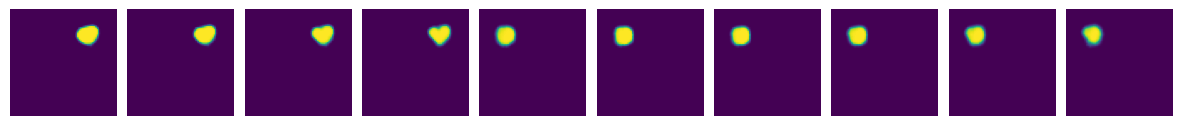

0.0001385971371028867


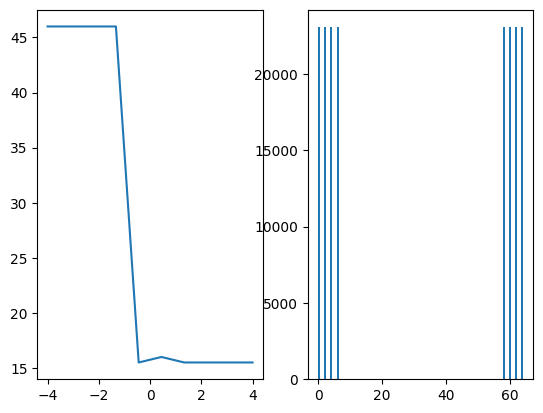

calulating metrics
{'dci.inf_train': 13.51329781639508, 'dci.inf_test': 10.548031735646267, 'dci.dis': 0.26549869469278436, 'dci.comp': 0.29716534095392183, 'importance_matrix': array([[0.08918086, 0.01760779, 0.1222795 , 0.31607106, 0.38477662],
       [0.09395953, 0.02345963, 0.14469296, 0.01834304, 0.27031174],
       [0.12818713, 0.02561448, 0.16352974, 0.009102  , 0.14339386],
       [0.39374566, 0.87079006, 0.17406826, 0.0067046 , 0.00392452],
       [0.13913539, 0.02620382, 0.20389195, 0.61900991, 0.18823756],
       [0.15579146, 0.0363242 , 0.19153756, 0.03076934, 0.00935559]]), 'dci.dis_per_code': array([0.19311202, 0.22338929, 0.18049669, 0.40628593, 0.20962935,
       0.24694607]), 'dci.completeness_per_factor': array([0.08907747, 0.67107409, 0.00774389, 0.48780284, 0.23012842]), 'DCIMIG': 0.08577387581605617}
Loading dataset for factor:posx with ds_rate:0.2
Dimension: 2, Ratio 0.34
Dataset has: 0.34% of the original dataset
traversing latent space


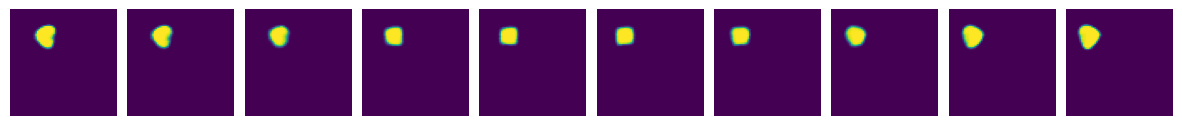

0.6153846153846154


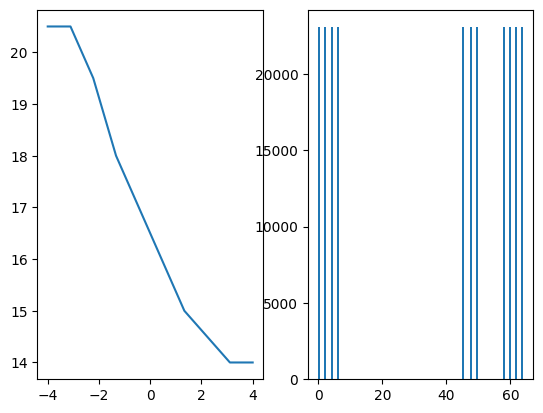

calulating metrics
{'dci.inf_train': 13.022759029372619, 'dci.inf_test': 9.713190858796832, 'dci.dis': 0.33652183956509224, 'dci.comp': 0.4355520878598636, 'importance_matrix': array([[1.62576795e-01, 2.22238097e-02, 1.22894086e-01, 7.46864011e-04,
        7.75183178e-03],
       [1.91944972e-01, 2.57877558e-02, 1.66220874e-01, 7.13494432e-04,
        4.24768180e-02],
       [9.75141674e-02, 1.79234594e-02, 1.62126020e-01, 9.84716788e-02,
        1.54880900e-02],
       [4.04270068e-02, 1.06503684e-02, 1.72716796e-01, 1.22543343e-03,
        3.08800399e-01],
       [7.44584575e-02, 1.58468951e-02, 2.05832168e-01, 8.97979379e-01,
        6.14422858e-01],
       [4.33078617e-01, 9.07567739e-01, 1.70210153e-01, 8.63159716e-04,
        1.10600246e-02]]), 'dci.dis_per_code': array([0.37794836, 0.29389962, 0.17523672, 0.39779773, 0.29504339,
       0.40912529]), 'dci.completeness_per_factor': array([0.14906875, 0.74712756, 0.00603738, 0.80480753, 0.47071926]), 'DCIMIG': 0.20915549048919238}


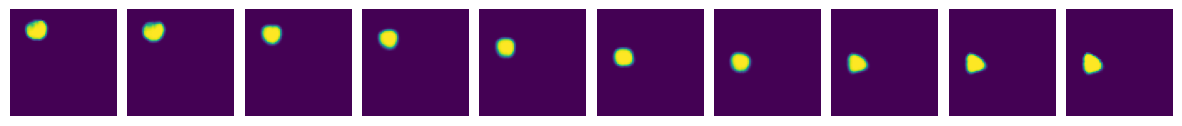

8.0


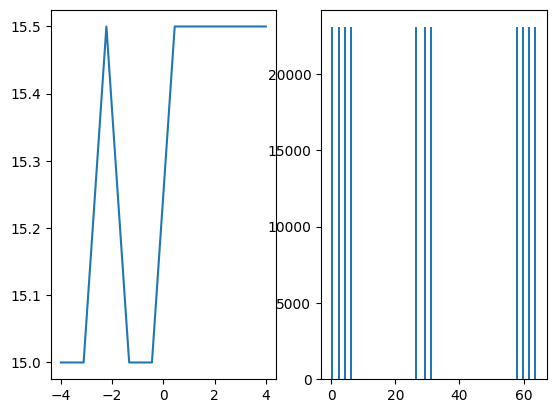

calulating metrics
{'dci.inf_train': 13.594423465899713, 'dci.inf_test': 10.19071346700731, 'dci.dis': 0.2752405664591856, 'dci.comp': 0.3274632546753613, 'importance_matrix': array([[0.07041836, 0.01266195, 0.12097504, 0.08202364, 0.05807884],
       [0.12076553, 0.02467587, 0.15295537, 0.00250234, 0.00514493],
       [0.1033828 , 0.02091524, 0.18411678, 0.1040375 , 0.58333814],
       [0.09397305, 0.0229701 , 0.15450765, 0.46961266, 0.26668942],
       [0.10572556, 0.01890633, 0.20112301, 0.33982471, 0.08139718],
       [0.50573474, 0.89987057, 0.18632212, 0.0019992 , 0.00535152]]), 'dci.dis_per_code': array([0.09551362, 0.36339768, 0.26827906, 0.19067298, 0.17801566,
       0.40008105]), 'dci.completeness_per_factor': array([0.17327325, 0.72976287, 0.00742439, 0.33601028, 0.39084545]), 'DCIMIG': 0.039086307330040225}
Loading dataset for factor:posx with ds_rate:0.4
Dimension: 4, Ratio 0.53
Dataset has: 0.53% of the original dataset
traversing latent space


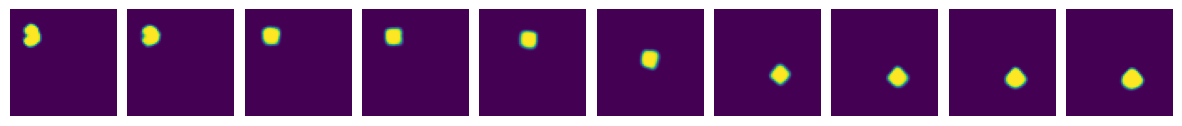

0.001224364860728497


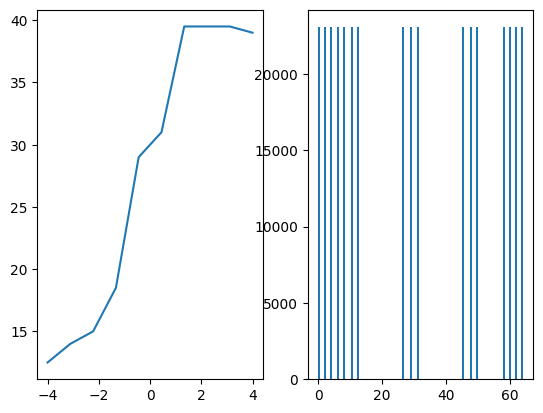

calulating metrics
{'dci.inf_train': 13.282657372961031, 'dci.inf_test': 9.719423189006635, 'dci.dis': 0.3769709066307776, 'dci.comp': 0.39377109567590407, 'importance_matrix': array([[2.59118885e-01, 2.88252626e-02, 1.71044841e-01, 8.19084060e-04,
        6.20726205e-04],
       [4.04795527e-01, 9.21282887e-01, 1.52366757e-01, 7.51315267e-04,
        8.85239046e-04],
       [2.82211751e-01, 3.54755893e-02, 1.53288513e-01, 8.92041193e-04,
        8.91513948e-04],
       [2.24379245e-02, 5.31667704e-03, 1.70358449e-01, 3.55591565e-01,
        2.70052969e-01],
       [1.68413613e-02, 4.58341744e-03, 1.82715699e-01, 3.22705209e-01,
        6.42278314e-01],
       [1.45945158e-02, 4.51624021e-03, 1.70225725e-01, 3.19240779e-01,
        8.52711797e-02]]), 'dci.dis_per_code': array([0.45009784, 0.44575917, 0.44628924, 0.26379727, 0.34308613,
       0.31734334]), 'dci.completeness_per_factor': array([0.28075631, 0.79175379, 0.00115421, 0.37789696, 0.51729417]), 'DCIMIG': 0.04695878562032886}


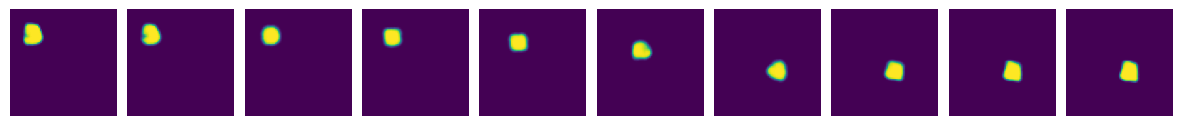

0.0020058215837371746


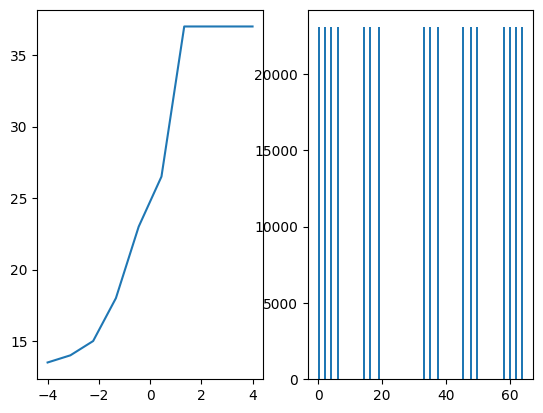

calulating metrics
{'dci.inf_train': 13.167039280638953, 'dci.inf_test': 9.551940114039505, 'dci.dis': 0.3530986493009678, 'dci.comp': 0.3646349828941082, 'importance_matrix': array([[3.65104169e-01, 9.04300988e-01, 1.23207994e-01, 6.02070300e-04,
        6.53975352e-04],
       [2.69570678e-01, 3.18125822e-02, 1.55781612e-01, 1.95118051e-03,
        7.52734079e-04],
       [2.88048148e-01, 4.74359691e-02, 1.75955638e-01, 9.04559449e-04,
        7.84240488e-04],
       [2.90480796e-02, 6.05696253e-03, 1.87745854e-01, 4.79415536e-01,
        4.69342768e-01],
       [2.50490755e-02, 5.42540243e-03, 1.77843690e-01, 3.16314697e-01,
        3.36079389e-01],
       [2.31798775e-02, 4.96815471e-03, 1.79465190e-01, 2.00811908e-01,
        1.92386866e-01]]), 'dci.dis_per_code': array([0.47000647, 0.44189145, 0.42069853, 0.28893848, 0.25702865,
       0.21892124]), 'dci.completeness_per_factor': array([0.23975411, 0.75954213, 0.00501102, 0.40734089, 0.41152674]), 'DCIMIG': 0.05245695849013138}
L

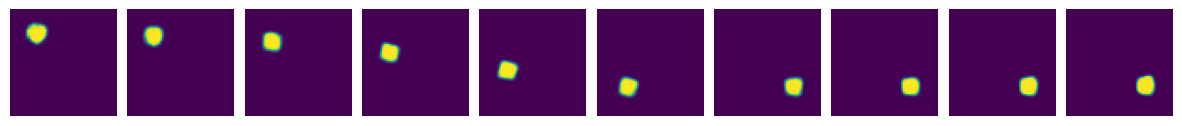

0.0001673596401767736


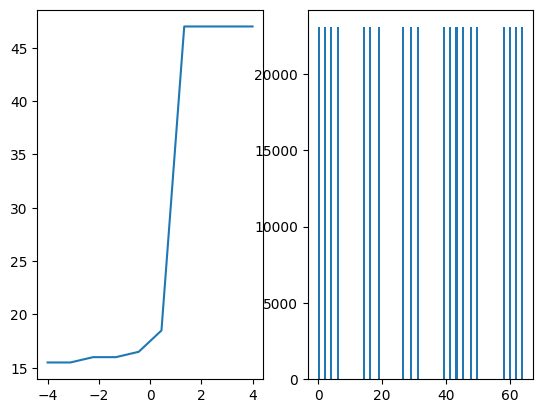

calulating metrics
{'dci.inf_train': 12.9661109202459, 'dci.inf_test': 10.158996741666185, 'dci.dis': 0.3717343752970136, 'dci.comp': 0.40123041608545706, 'importance_matrix': array([[2.09713548e-01, 2.33775061e-02, 1.44762725e-01, 7.46225356e-04,
        5.64511865e-04],
       [3.68716091e-01, 4.81611118e-02, 1.62320718e-01, 8.45242466e-04,
        8.11165606e-04],
       [3.59808117e-01, 9.17613626e-01, 1.69789866e-01, 9.43408639e-04,
        7.79811060e-04],
       [3.03181298e-02, 4.31790436e-03, 1.75287485e-01, 3.61142337e-01,
        4.36577350e-01],
       [1.66201852e-02, 3.04989121e-03, 1.65511981e-01, 4.91864949e-01,
        5.03612280e-01],
       [1.48238568e-02, 3.47991148e-03, 1.82327211e-01, 1.44457817e-01,
        5.76548688e-02]]), 'dci.dis_per_code': array([0.44768593, 0.45949434, 0.44372584, 0.27728397, 0.32954268,
       0.27465404]), 'dci.completeness_per_factor': array([0.2745887 , 0.79145636, 0.00141208, 0.43394253, 0.50475242]), 'DCIMIG': 0.03298268167127211}
L

0.09876543209876543


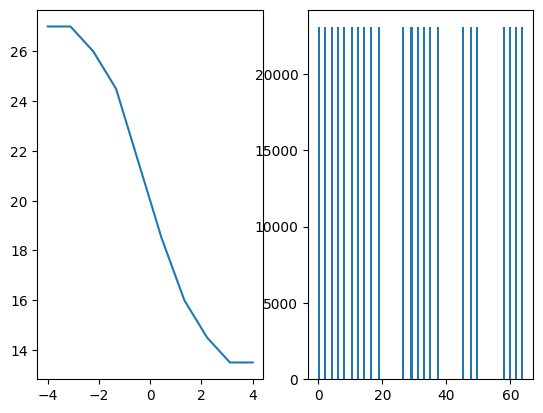

calulating metrics
{'dci.inf_train': 15.62698658837041, 'dci.inf_test': 11.594808840443756, 'dci.dis': 0.3407749341883609, 'dci.comp': 0.39859795259915615, 'importance_matrix': array([[1.16863951e-01, 2.49743443e-02, 1.44178852e-01, 5.52380204e-01,
        3.40343118e-02],
       [3.23515348e-02, 5.47363423e-03, 1.54317811e-01, 2.26996571e-01,
        2.54059210e-02],
       [3.32614742e-02, 6.95408834e-03, 1.53487548e-01, 5.65537205e-03,
        7.92011898e-03],
       [4.41148803e-02, 1.08198049e-02, 1.86398208e-01, 4.17515635e-02,
        5.92169821e-01],
       [6.42795920e-01, 9.25413072e-01, 1.76688015e-01, 9.04240995e-04,
        1.05614029e-03],
       [1.30612254e-01, 2.63650753e-02, 1.84929594e-01, 1.72311977e-01,
        3.39413702e-01]]), 'dci.dis_per_code': array([0.32620162, 0.30479404, 0.47001784, 0.41360291, 0.41309005,
       0.12036733]), 'dci.completeness_per_factor': array([0.35108857, 0.79250931, 0.00277981, 0.36617982, 0.48043226]), 'DCIMIG': 0.15542125957228123}


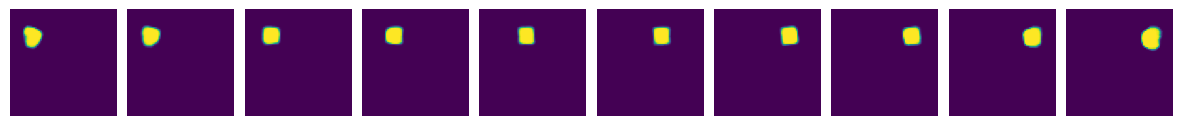

0.002659394883781327


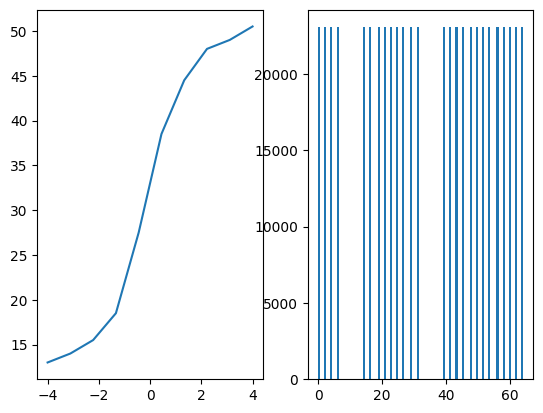

calulating metrics
{'dci.inf_train': 13.394694801745455, 'dci.inf_test': 10.206370356933096, 'dci.dis': 0.5865075234539612, 'dci.comp': 0.6077952060695029, 'importance_matrix': array([[9.00343712e-03, 2.47192755e-03, 1.12435415e-01, 6.23018073e-04,
        4.71625564e-04],
       [2.54124641e-01, 8.53429258e-01, 1.37917429e-01, 6.51886046e-04,
        5.92718716e-04],
       [4.50082660e-01, 6.98121786e-02, 1.86503947e-01, 7.32256100e-04,
        9.01874679e-04],
       [4.82821791e-03, 1.85501273e-03, 1.58086136e-01, 5.98541286e-04,
        9.96802449e-01],
       [2.73762876e-03, 2.20553554e-03, 1.63771987e-01, 9.96570408e-01,
        4.65509132e-04],
       [2.79223382e-01, 7.02260062e-02, 2.41285056e-01, 8.23906157e-04,
        7.65863515e-04]]), 'dci.dis_per_code': array([0.74534154, 0.48132538, 0.45109588, 0.72663023, 0.72724961,
       0.38431479]), 'dci.completeness_per_factor': array([0.35930363, 0.69436841, 0.0159899 , 0.98415896, 0.98515509]), 'DCIMIG': 0.3347543184860321}
L

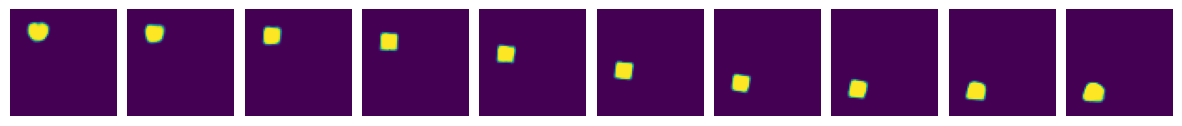

1.641025641025641


calulating metrics
{'dci.inf_train': 12.931413605201358, 'dci.inf_test': 9.929250540129122, 'dci.dis': 0.573969432702596, 'dci.comp': 0.5626531594730724, 'importance_matrix': array([[3.62793595e-01, 5.43158725e-02, 1.67052269e-01, 5.46337920e-04,
        6.13912125e-04],
       [2.79712617e-01, 8.76769125e-01, 1.47871032e-01, 7.05131330e-04,
        5.78812440e-04],
       [9.83710866e-04, 2.90698628e-03, 1.42674029e-01, 2.00642213e-01,
        4.69876686e-04],
       [1.19955081e-03, 1.42431795e-03, 1.57375783e-01, 7.96731770e-01,
        4.36856673e-04],
       [4.92326159e-04, 1.55220961e-03, 1.53139904e-01, 5.83540706e-04,
        9.97114658e-01],
       [3.54818135e-01, 6.30315244e-02, 2.31886938e-01, 7.91114289e-04,
        7.85922108e-04]]), 'dci.dis_per_code': array([0.44785278, 0.47084591, 0.53505207, 0.70728062, 0.74541344,
       0.41542111]), 'dci.completeness_per_factor': array([0.38023501, 0.72981621, 0.00843223, 0.70836374, 0.98641853]), 'DCIMIG': 0.3025099297603435}
Dim

0.0038459804996769974


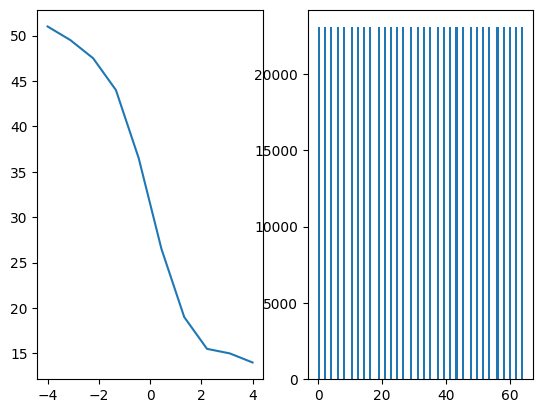

calulating metrics
{'dci.inf_train': 13.051762512855374, 'dci.inf_test': 9.768167990405624, 'dci.dis': 0.5715641873488235, 'dci.comp': 0.5575719865258054, 'importance_matrix': array([[2.07541115e-03, 1.30716409e-03, 1.08344592e-01, 9.95661914e-01,
        2.74060440e-04],
       [3.49689275e-01, 7.05682114e-02, 2.34072998e-01, 1.05773762e-03,
        8.64309375e-04],
       [1.56673091e-03, 1.54422305e-03, 1.42697260e-01, 6.49672467e-04,
        7.76471496e-01],
       [1.22882752e-03, 1.43422105e-03, 1.28787622e-01, 6.76142750e-04,
        2.21103668e-01],
       [2.97560334e-01, 8.68138611e-01, 1.63700953e-01, 9.28953639e-04,
        5.79653832e-04],
       [3.47879380e-01, 5.70075624e-02, 2.22396612e-01, 1.02556625e-03,
        7.06856954e-04]]), 'dci.dis_per_code': array([0.78564854, 0.40225465, 0.71378608, 0.55565487, 0.45333898,
       0.42161934]), 'dci.completeness_per_factor': array([0.3712284 , 0.72026675, 0.02159375, 0.98056492, 0.69420614]), 'DCIMIG': 0.33857710421204257}


In [18]:
dimensions_posx=[4,2,3,4,4,4,1,4,4,0]
true_dimensions = []
#4]
true_dim=3
dimensions_posy=[3,3,7,4,7,3,7,3,3,3]

dimensions=dimensions_posx
rates=[i/10 for i in range(1,11)]
lower_bound = -4
upper_bound = 4
code_sample_size = 10
r2_scores,x_p,dy_dx=[],[],[]
factor_name="Position X"
errors,scores=[],[]
migs,dcimigs=[],[]
true_ratios=[]
info,completness,modularity=[],[],[]
migs_dim,dcimigs_dim,smoothness,r2_scores=[],[],[],[]
factor="posx"
ind=0
ds_ref=get_dataset(1,factor)
rate=1
num_train=2000
num_test=500
d_res=[]
model.eval()
train_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_train)
train_imgs = [ds_ref.__getitem__(ind)[0] for ind in train_imgs_indices]

train_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in train_imgs_indices]).T
test_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_test)
test_imgs = [ds_ref.__getitem__(ind)[0] for ind in test_imgs_indices]
transforms_ds = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
test_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in test_imgs_indices]).T
for d,r in zip(dimensions,rates):
    
    ds = get_dataset(rate=r,factor=factor)
    all_posx=all_posx_rates[ind]
    all_posx=[i*2 for i in all_posx]
    true_ratios.append(round(float(ds.__len__()/737280),2))
    print("Dimension: {}, Ratio {}".format(d,true_ratios[-1]))
    print("Dataset has: {}% of the original dataset".format(round(ds.__len__()/737280,2)))
    img,l = ds.__getitem__(0)
    data=img
    model = get_model(r,z=6,factor=factor)
    mus_train = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in train_imgs])
    mus_train = np.squeeze(mus_train,axis=1).T
    mus_test = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in test_imgs])
    mus_test = np.squeeze(mus_test,axis=1).T
    traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
    print("traversing latent space")
    images = traverse_latent(data, device, model, d, code_sample_size,lower_bound,upper_bound,plot=True,n_cols=code_sample_size)
    _,centers = get_centers_mov(images)
    x_progress = [i[0] for i in centers]
    smoothness.append(1/np.var(np.diff(np.diff(x_progress)))/(max(x_progress)-min(x_progress)))
    res = stats.linregress(traversals, x_progress)
    r2_scores.append(round(res.rvalue**2,3))
    smoothness.append(1/np.var(np.diff(np.diff(x_progress)))/(max(x_progress)-min(x_progress)))
    print(smoothness[-1])
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(traversals,x_progress)
    ax[1].hist(all_posx,bins=100)
    plt.show()
    print("calulating metrics")
    dcimig_dim = evaluate_metrics(mus_train,train_labels,mus_test,test_labels,model,dimension=true_dim,dimensions=[dim,true_dim])
    print(dcimig_dim)
    #print(completness)
    
    x_p.append(x_progress)
    ind+=1

In [19]:
dimensions_posx=[5,2,1,4,7]

rates=[i/10 for i in range(2,11,2)]
lower_bound = -2
upper_bound = 2
code_sample_size=100
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
img,l = ds.__getitem__(0)
data=img
factor="scale"
r2_scores=[]
x_p=[]
for r,dim in zip(rates,dimensions_posx):
    model = get_model(r,z=8,factor=factor)
    images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=False,n_cols=code_sample_size)
    _,x_progress = get_surface_mov(images)
    x_p.append([i * 32 for i in x_progress])
fig,ax=plt.subplots(1,5,figsize=(20,5))    
for i in range(len(x_p)):
    ax[i].plot(traversals,x_p[i])
    ax[i].set_title("{}%".format(rates[i]*100))
    ax[i].set_xlabel("code value")
ax[0].set_ylabel("Size")
fig.savefig("recovering_scale_dspr.png")
plt.show()    

In [21]:
from xgboost import XGBRegressor
def compute_info(model, train_img, train_labels, test_imgs, test_labels, code_dim, gen_dim):
    transforms_ds = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    x_train = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in train_imgs])  
    #x_train = x_train.squeeze(1)[:,code_dim].reshape(-1,1)
    x_train = x_train.squeeze(1)
    x_test = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in test_imgs])
    #x_test = x_test.squeeze(1)[:,code_dim].reshape(-1,1)
    x_test = x_test.squeeze(1)
    #_,centers = get_centers_mov([img.cpu().detach().numpy() for img in train_img])
    #x_progress = np.array([i[0] for i in centers]).reshape(-1,1)
    
    y_train=train_labels.T[:,gen_dim].reshape(-1,1)
    #print(y_train.shape," ",x_train.shape)
    #_,centers = get_centers_mov([img.cpu().detach().numpy() for img in test_imgs])
    #x_progress = np.array([i[0] for i in centers]).reshape(-1,1)
    #y_test=x_progress/
    y_test=test_labels.T[:,gen_dim].reshape(-1,1)
   # print(y_test.shape," ",x_test.shape)
    predictor = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
    X_tr,Y_tr=x_train, y_train
    X_te,Y_te=x_test, y_test
    predictor.fit(X_tr,Y_tr)
    train_loss=mean_squared_error(predictor.predict(X_tr), Y_tr)
    test_loss=mean_squared_error(predictor.predict(X_te), Y_te)
    return 1/train_loss, 1/test_loss
def compute_imp_matrix(model, train_imgs, train_labels):
    transforms_ds = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])
    x_train = np.array([model.encoder(transforms_ds(x).to(device))[0].cpu().detach().numpy()  for x in train_imgs])  
    x_train = x_train.squeeze(1)
    
    y_train=train_labels.T
    n_factors,n_codes=y_train.shape[1],x_train.shape[1]
    importance_matrix=np.zeros((n_codes,n_factors))
    for factor in range(n_factors):
        predictor = XGBRegressor(tree_method='gpu_hist', gpu_id=7)
        X_tr,Y_tr=x_train, y_train[:,factor].reshape(-1,1)
        predictor.fit(X_tr,Y_tr)
        importance_matrix[:, factor] = np.abs(predictor.feature_importances_)
    return importance_matrix    
    

In [33]:
## Traversing all the downsampled models at Position X

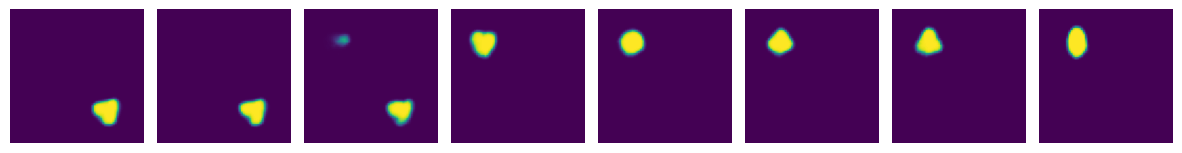

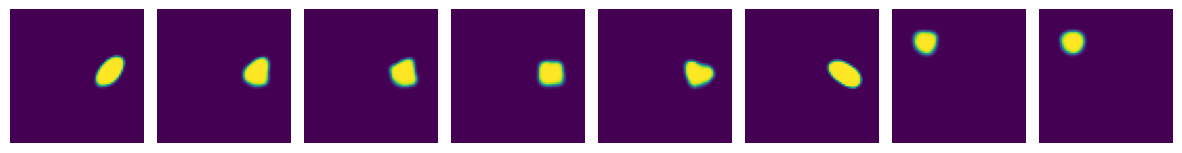

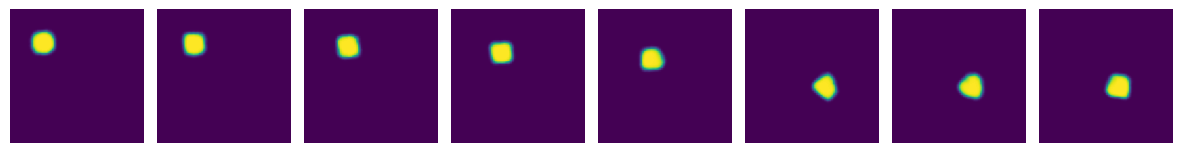

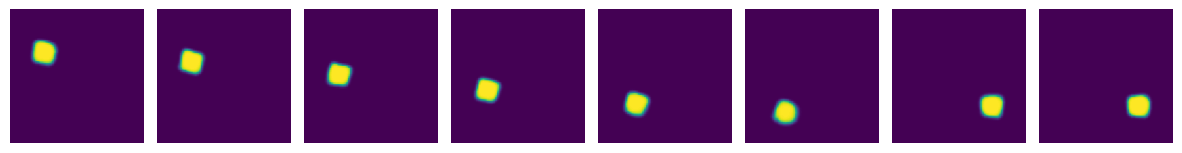

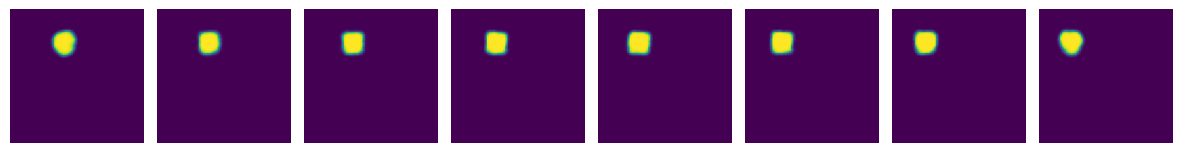

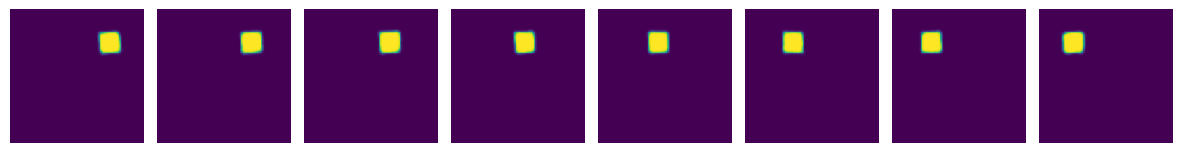

In [22]:
import matplotlib
dimensions_posx=[0,4,4,5,4,4,1,4,2,0]
rates=[i/10 for i in range(1,11)]
lower_bound,upper_bound=-2,2
code_sample_size=8
#all_info_test_6,all_dis_6,all_comp_6=[],[],[]
dim_true=3
num_train,num_test=600,200
factor="posx"
all_images=[]
for r, dim in zip(rates,dimensions_posx):
        model=get_model(r,z=6,factor=factor)
        images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=True,n_cols=code_sample_size)
        all_images.extend([torch.tensor(i).permute(2,1,0) for i in images])
plt.show()

 90%|███████████████████████████████████████▌    | 9/10 [04:57<00:32, 32.07s/it]

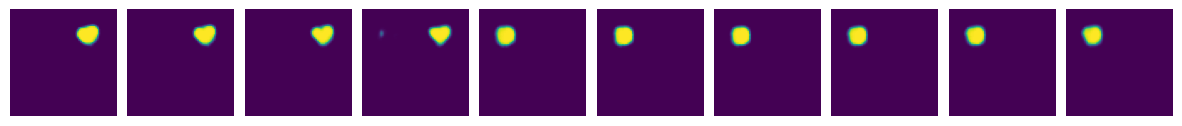

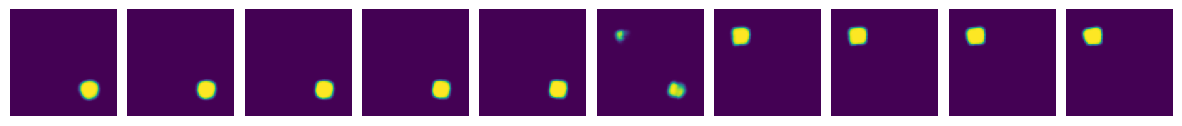

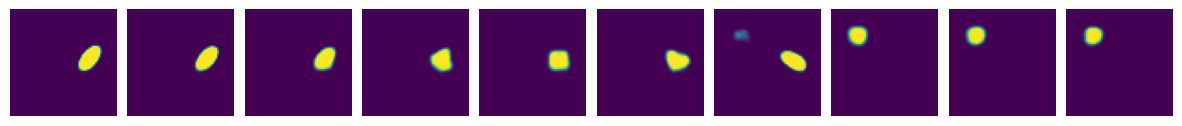

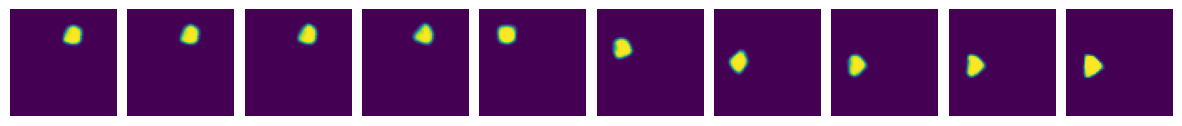

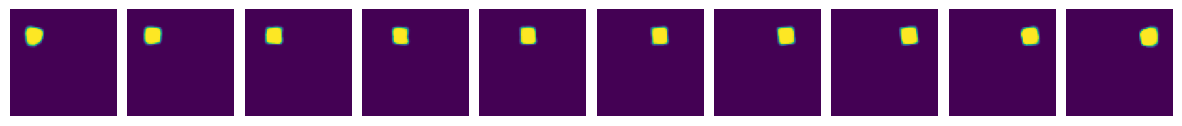

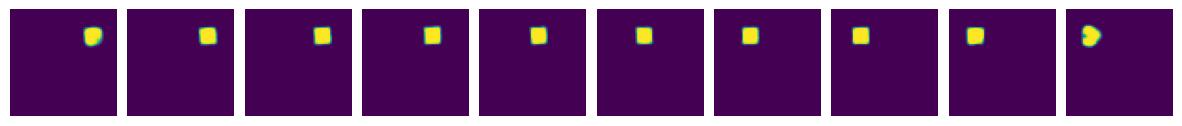

100%|███████████████████████████████████████████| 10/10 [05:32<00:00, 33.29s/it]


In [23]:
dimensions_posx=[4,4,4,5,3,4,0,4,2,0]
rates=[i/10 for i in range(1,11)]
lower_bound,upper_bound=-3,3
code_sample_size=10
all_info_test_6,all_dis_6,all_comp_6=[],[],[]
all_smooth=[]
min_val,max_val=1,64
dim_true=3
num_train,num_test=600,200
factor="posx"
plot=False
for i in tqdm(range(10)):
    train_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_train)
    train_imgs = [ds_ref.__getitem__(ind)[0] for ind in train_imgs_indices]
    info_temp,dis_temp,comp_temp,smoothness=[],[],[],[]
    train_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in train_imgs_indices]).T
    test_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_test)
    test_imgs = [ds_ref.__getitem__(ind)[0] for ind in test_imgs_indices]
    test_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in test_imgs_indices]).T
    for r, dim in zip(rates,dimensions_posx):
        #print(r)
        model=get_model(r,z=6,factor=factor)
        if i == 9:
            plot=True
        images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=plot,n_cols=code_sample_size)
        _,centers = get_centers_mov(images)
        x_progress = [i[0] for i in centers]
        max_val,min_val=max(x_progress),min(x_progress)
        smoothness.append(1/(np.max(abs(np.diff(x_progress)))/(max_val-min_val)))
        info_tr,info_te=compute_info(model,train_imgs,train_labels,test_imgs,test_labels,code_dim=dim,gen_dim=dim_true)
        importance_matrix=compute_imp_matrix(model, train_imgs, train_labels)
        dis_codes =  _disentanglement_per_code(importance_matrix)  
        completeness_factors = _completeness_per_factor(importance_matrix)
        dis_temp.append(dis_codes[dim])
        comp_temp.append(completeness_factors[dim_true])
        info_temp.append(info_te)
    all_info_test_6.append(info_temp)
    all_dis_6.append(dis_temp)
    all_comp_6.append(comp_temp)
    all_smooth.append(smoothness)
all_info_test_6=np.array(all_info_test_6)
all_dis_6=np.array(all_dis_6)
all_comp_6=np.array(all_comp_6)
all_smooth=np.array(all_smooth)


In [24]:
fig,ax=plt.subplots(2,2,figsize=(17,7))
ax[0,0].plot(rates,np.mean(all_info_test_6,axis=0),label="Info")
ax[0,0].set_title("Informativeness")
#ax[0].xaxis.set_ticks([i for i in range(1,11)])
ax[0,1].plot(rates,np.mean(all_dis_6,axis=0),label="Disent")
ax[0,1].set_title("Disentanglement")
#ax[1].xaxis.set_ticks([i for i in range(1,11)])
ax[1,0].plot(rates,np.mean(all_comp_6,axis=0),label="Comp")
ax[1,0].set_title("Completeness")
ax[1,1].plot(rates,np.mean(all_smooth,axis=0),label="Smoothness")
ax[1,1].set_title("Smoothness")
fig.tight_layout()

#ax[2].xaxis.set_ticks([i for i in range(1,11)])
fig.savefig('Interpolation_dspr_posx.png')
plt.show()


In [ ]:
## Traversing all the models at Y Position

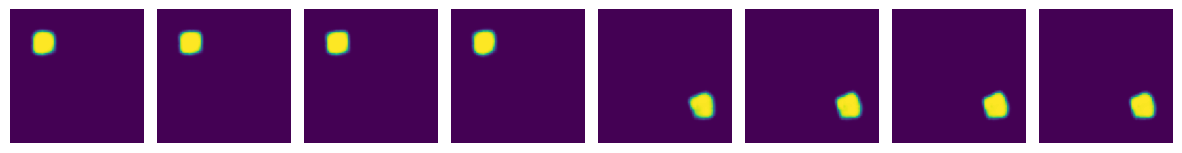

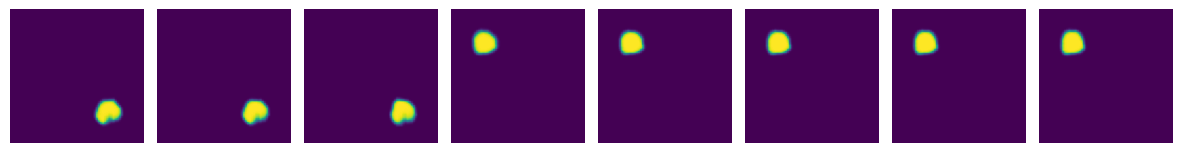

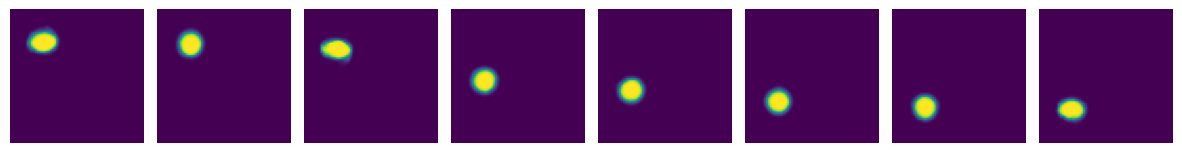

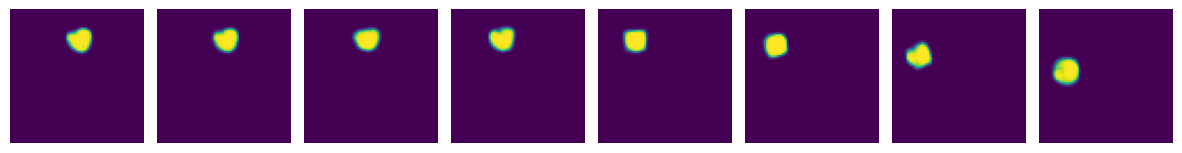

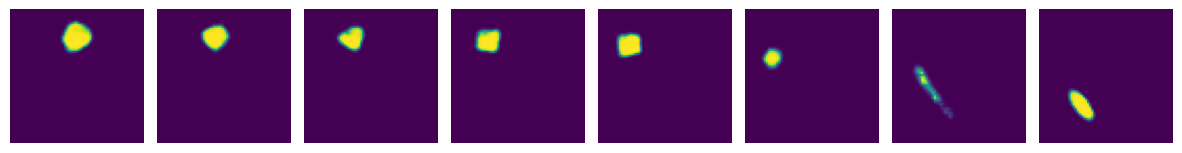

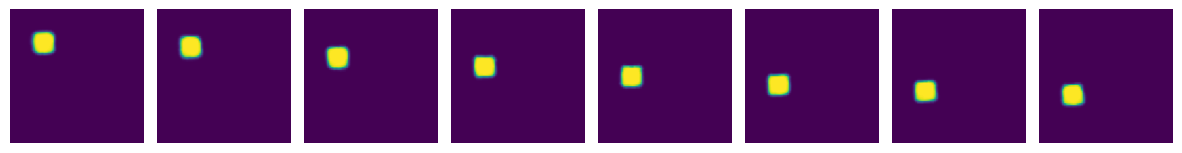

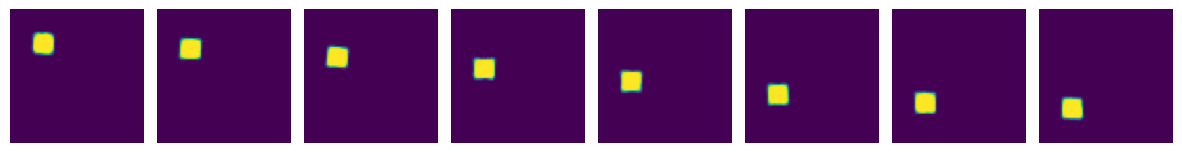

In [25]:
import matplotlib
dimensions_posx=[3,3,5,4,7,3,7,3,3,3]
rates=[i/10 for i in range(1,11)]
lower_bound,upper_bound=-2,2
code_sample_size=8
#all_info_test_6,all_dis_6,all_comp_6=[],[],[]
dim_true=3

num_train,num_test=600,200
factor="posy"
all_images=[]
for r, dim in zip(rates,dimensions_posx):
        model=get_model(r,z=8,factor=factor)
        images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=True,n_cols=code_sample_size)
        all_images.extend([torch.tensor(i).permute(2,1,0) for i in images])
plt.show()

 90%|███████████████████████████████████████▌    | 9/10 [04:58<00:34, 34.65s/it]

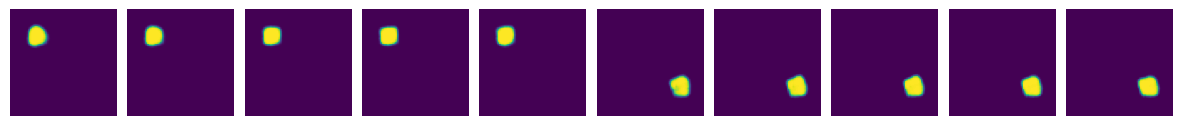

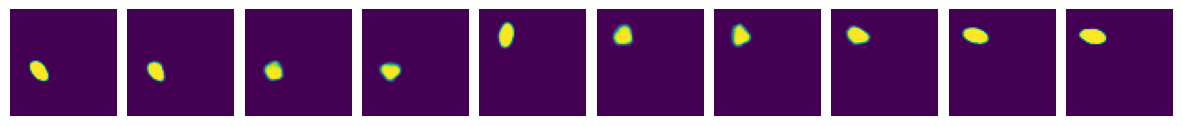

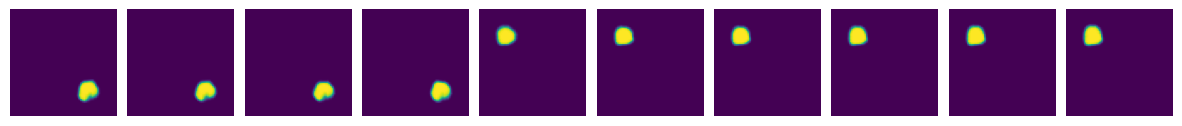

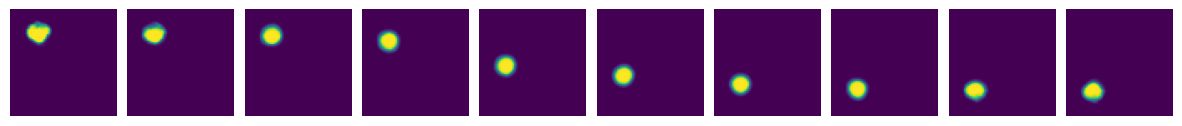

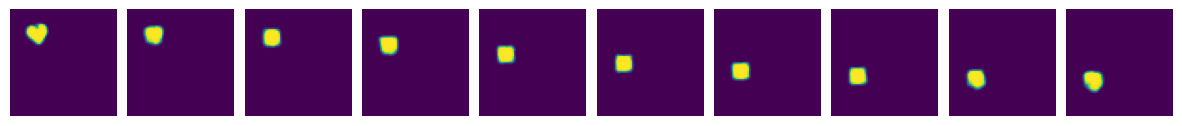

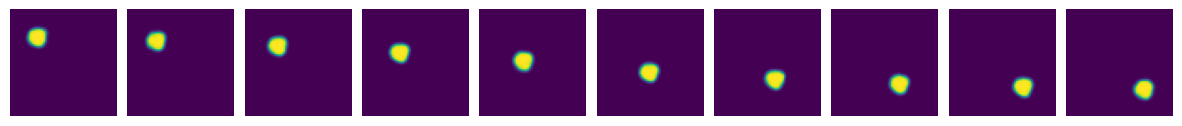

100%|███████████████████████████████████████████| 10/10 [05:34<00:00, 33.42s/it]


In [26]:
dimensions_posy=[3,3,5,4,7,3,7,3,3,3]
rates=[i/10 for i in range(1,11)]
lower_bound,upper_bound=-3,3
code_sample_size=10
all_info_test_6,all_dis_6,all_comp_6=[],[],[]
all_smooth=[]
min_val,max_val=1,64
dim_true=4
factor="posy"
plot=False
num_train,num_test=600,200
for i in tqdm(range(10)):
    train_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_train)
    train_imgs = [ds_ref.__getitem__(ind)[0] for ind in train_imgs_indices]
    info_temp,dis_temp,comp_temp,smoothness=[],[],[],[]
    train_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in train_imgs_indices]).T
    test_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_test)
    test_imgs = [ds_ref.__getitem__(ind)[0] for ind in test_imgs_indices]
    test_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in test_imgs_indices]).T
    for r, dim in zip(rates,dimensions_posy):
        model=get_model(r,z=8,factor=factor)
        if i==9:
            plot=True
        images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=plot,n_cols=code_sample_size)
        _,centers = get_centers_mov(images)
        x_progress = [i[1] for i in centers]
        max_val,min_val=max(x_progress),min(x_progress)
        #print(np.diff(x_progress))
        smoothness.append(1/(np.max(abs(np.diff(x_progress)))/(max_val-min_val)))
        info_tr,info_te=compute_info(model,train_imgs,train_labels,test_imgs,test_labels,code_dim=dim,gen_dim=dim_true)
        importance_matrix=compute_imp_matrix(model, train_imgs, train_labels)
        dis_codes =  _disentanglement_per_code(importance_matrix)  
        completeness_factors = _completeness_per_factor(importance_matrix)
        dis_temp.append(dis_codes[dim])
        comp_temp.append(completeness_factors[dim_true])
        info_temp.append(info_te)
    all_info_test_6.append(info_temp)
    all_dis_6.append(dis_temp)
    all_comp_6.append(comp_temp)
    all_smooth.append(smoothness)
all_info_test_6=np.array(all_info_test_6)
all_dis_6=np.array(all_dis_6)
all_comp_6=np.array(all_comp_6)
all_smooth=np.array(all_smooth)



In [27]:
fig,ax=plt.subplots(2,2,figsize=(17,7))
ax[0,0].plot(rates,np.mean(all_info_test_6,axis=0),label="Info")
ax[0,0].set_title("Informativeness")
#ax[0].xaxis.set_ticks([i for i in range(1,11)])
ax[0,1].plot(rates,np.mean(all_dis_6,axis=0),label="Disent")
ax[0,1].set_title("Disentanglement")
#ax[1].xaxis.set_ticks([i for i in range(1,11)])
ax[1,0].plot(rates,np.mean(all_comp_6,axis=0),label="Comp")
ax[1,0].set_title("Completeness")
ax[1,1].plot(rates,np.mean(all_smooth,axis=0),label="Smoothness")
ax[1,1].set_title("Smoothness")
fig.tight_layout()

#ax[2].xaxis.set_ticks([i for i in range(1,11)])
fig.savefig('Interpolation_dspr_posy.png')
plt.show()

In [28]:
dimensions_scale=[5,2,2,3,4]
rates=[i/10 for i in range(2,11,2)]
lower_bound,upper_bound=-2,2
code_sample_size=10
all_info_test_6,all_dis_6,all_comp_6=[],[],[]
all_smooth=[]
min_val,max_val=0.1220703125,0.9765625
dim_true=1
num_train,num_test=600,200
factor="scale"
plot=False
for i in tqdm(range(10)):
    train_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_train)
    train_imgs = [ds_ref.__getitem__(ind)[0] for ind in train_imgs_indices]
    info_temp,dis_temp,comp_temp,smoothness=[],[],[],[]
    train_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in train_imgs_indices]).T
    test_imgs_indices = random.sample(range(0, ds_ref.__len__()),num_test)
    test_imgs = [ds_ref.__getitem__(ind)[0] for ind in test_imgs_indices]
    test_labels = np.array([ds_ref.__getitem__(ind)[1] for ind in test_imgs_indices]).T
    for r, dim in zip(rates,dimensions_scale):
        model=get_model(r,z=6,factor=factor)
        if i==10:
            plot=True
        images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=plot,n_cols=code_sample_size)
        _,sizes=get_surface_mov(images)
        
        max_val,min_val=max(sizes),min(sizes)
        
        smoothness.append(1/(np.max(abs(np.diff(sizes)))/(max_val-min_val)))
        info_tr,info_te=compute_info(model,train_imgs,train_labels,test_imgs,test_labels,code_dim=dim,gen_dim=dim_true)
        importance_matrix=compute_imp_matrix(model, train_imgs, train_labels)
        dis_codes =  _disentanglement_per_code(importance_matrix)  
        completeness_factors = _completeness_per_factor(importance_matrix)
        dis_temp.append(dis_codes[dim])
        comp_temp.append(completeness_factors[dim_true])
        info_temp.append(info_te)
    all_info_test_6.append(info_temp)
    all_dis_6.append(dis_temp)
    all_comp_6.append(comp_temp)
    all_smooth.append(smoothness)
all_info_test_6=np.array(all_info_test_6)
all_dis_6=np.array(all_dis_6)
all_comp_6=np.array(all_comp_6)
all_smooth=np.array(all_smooth)



100%|███████████████████████████████████████████| 10/10 [02:38<00:00, 15.87s/it]


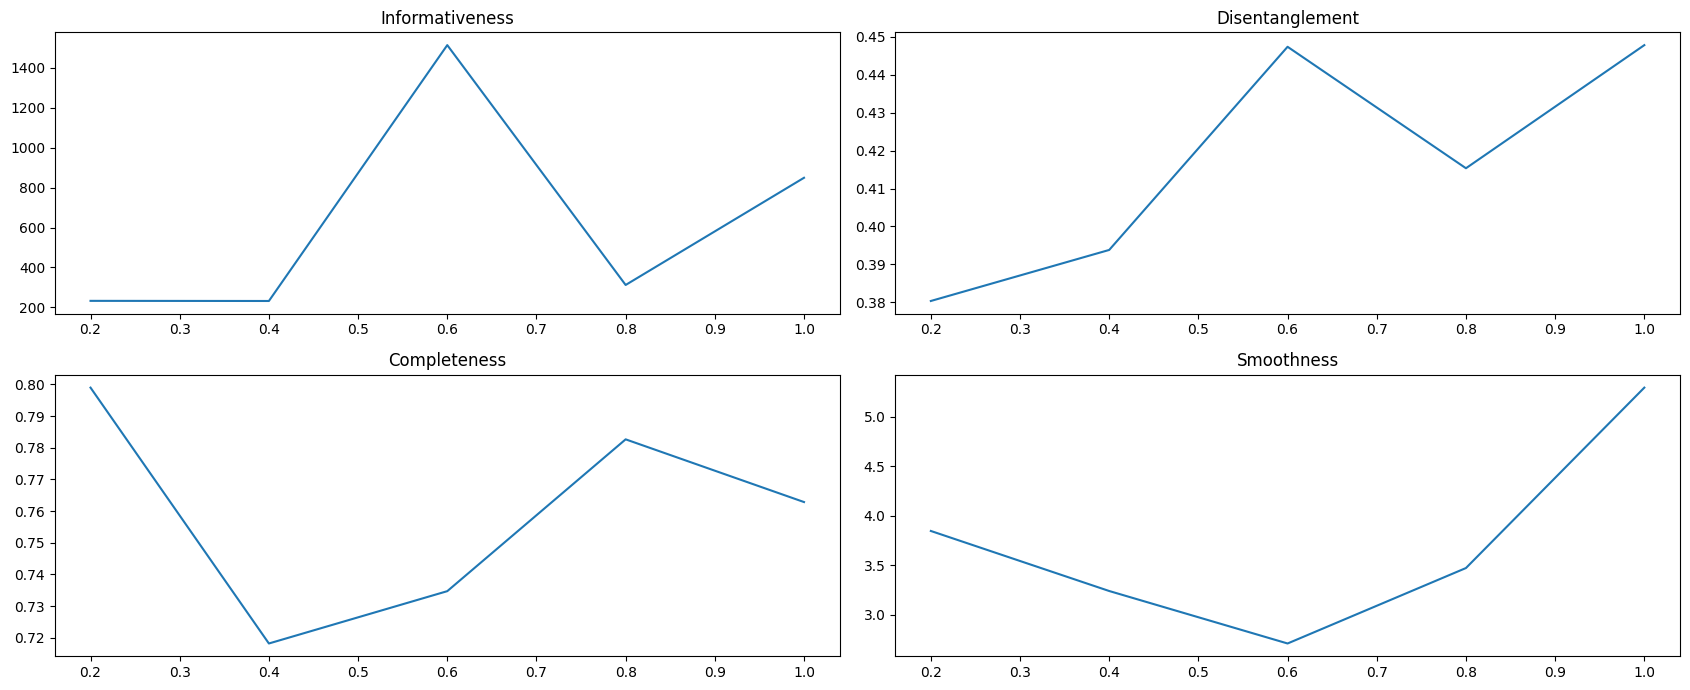

In [29]:
fig,ax=plt.subplots(2,2,figsize=(17,7))
ax[0,0].plot(rates,np.mean(all_info_test_6,axis=0),label="Info")
ax[0,0].set_title("Informativeness")
#ax[0].xaxis.set_ticks([i for i in range(1,11)])
ax[0,1].plot(rates,np.mean(all_dis_6,axis=0),label="Disent")
ax[0,1].set_title("Disentanglement")
#ax[1].xaxis.set_ticks([i for i in range(1,11)])
ax[1,0].plot(rates,np.mean(all_comp_6,axis=0),label="Comp")
ax[1,0].set_title("Completeness")
ax[1,1].plot(rates,np.mean(all_smooth,axis=0),label="Smoothness")
ax[1,1].set_title("Smoothness")
fig.tight_layout()
#ax[2].xaxis.set_ticks([i for i in range(1,11)])
fig.savefig('Interpolation_dspr_scale.png')
plt.show()

In [ ]:
# Traversing all the downsampled models on the size factor 

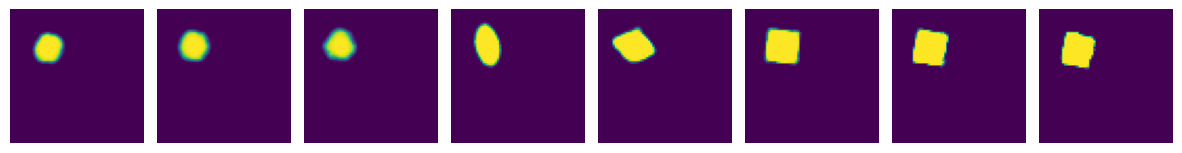

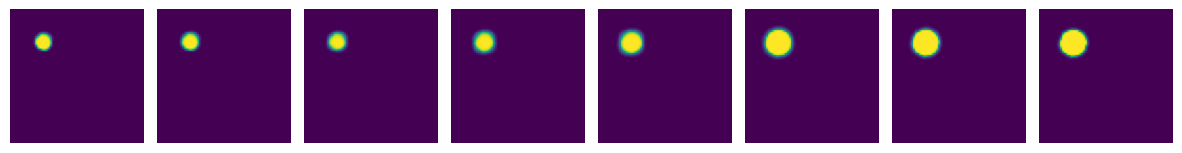

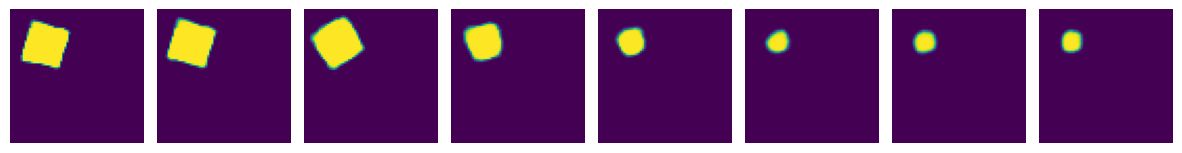

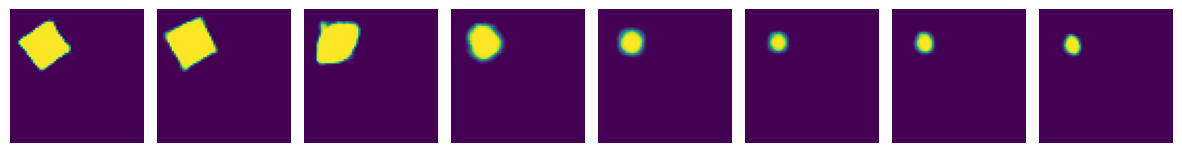

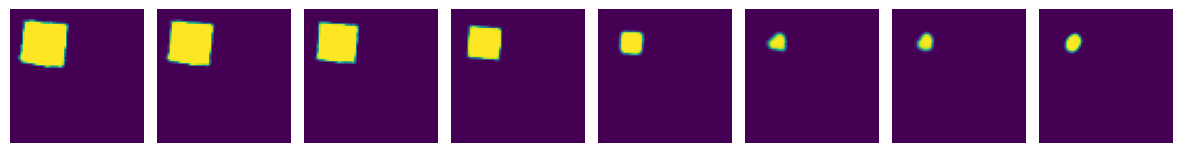

In [30]:
import matplotlib
rates=[i/10 for i in range(2,11,2)]
scale_8=[5,2,1,4,7]
lower_bound,upper_bound=-4,4
code_sample_size=8
#all_info_test_6,all_dis_6,all_comp_6=[],[],[]
dim_true=3
num_train,num_test=600,200
factor="scale"
all_images=[]
for r, dim in zip(rates,scale_8):
        model=get_model(r,z=8,factor=factor)
        images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=True,n_cols=code_sample_size)
        all_images.extend([torch.tensor(i).permute(2,1,0) for i in images])
plt.show()

0.2   5


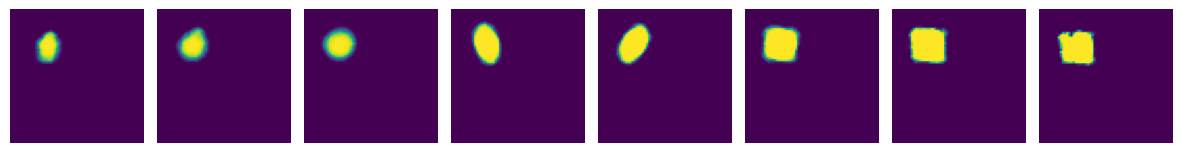

[0.02734375, 0.033935546875, 0.03759765625, 0.0458984375, 0.0478515625, 0.059814453125, 0.063720703125, 0.057373046875]


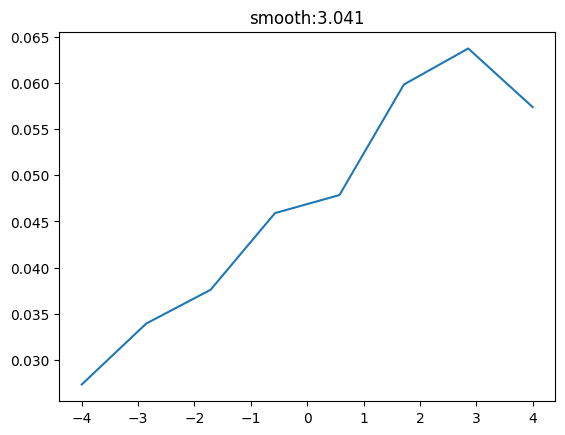

0.4   2


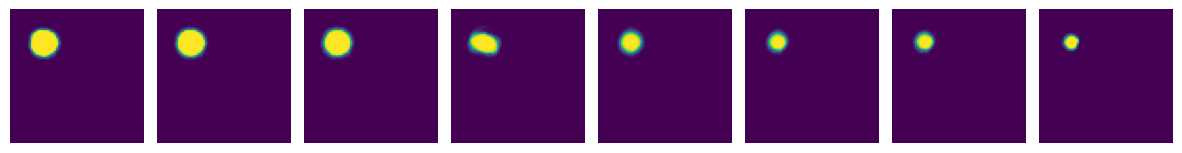

[0.035888671875, 0.036376953125, 0.03564453125, 0.02783203125, 0.021240234375, 0.01611328125, 0.014892578125, 0.009521484375]


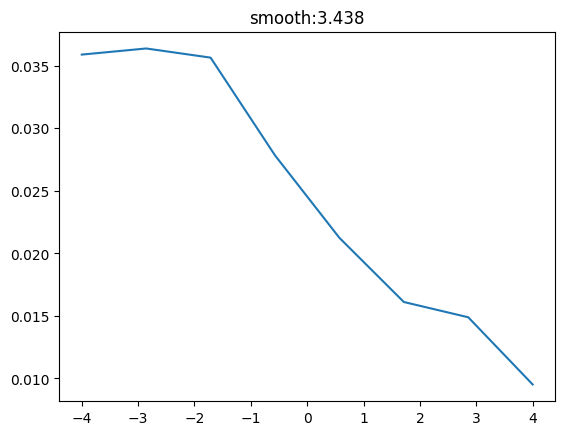

0.6   2


[0.08349609375, 0.08935546875, 0.093994140625, 0.060546875, 0.034912109375, 0.0224609375, 0.02294921875, 0.021240234375]


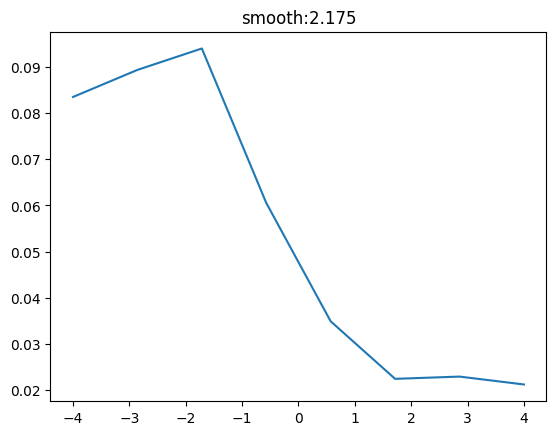

0.8   3


[0.079345703125, 0.090576171875, 0.08447265625, 0.04541015625, 0.0234375, 0.013671875, 0.011962890625, 0.011962890625]


1.0   4


[0.1064453125, 0.0966796875, 0.080078125, 0.0517578125, 0.025146484375, 0.015869140625, 0.01416015625, 0.013671875]


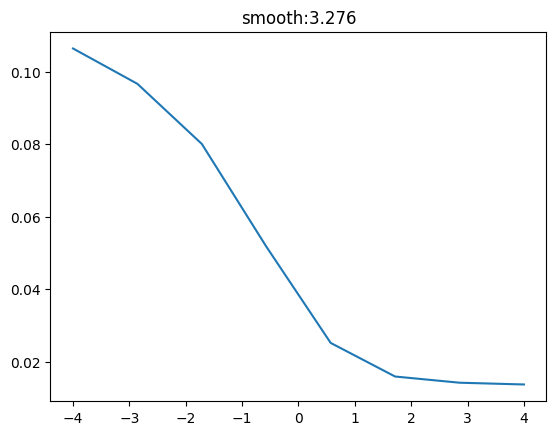

In [31]:
import matplotlib
scale_8=[5,2,1,4,7]
scale_6=[5,2,2,3,4]
r=1
rates=[i/10 for i in range(2,11,2)]
lower_bound,upper_bound=-4,4
code_sample_size=8
#all_info_test_6,all_dis_6,all_comp_6=[],[],[]
dim_true=3
num_train,num_test=600,200
all_images=[]

factor="scale"
model=get_model(r,z=8,factor=factor)
traversals = torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
for r,dim in zip(rates,scale_6):
    print(r," ",dim)
    model=get_model(r,z=6,factor=factor)
    images = traverse_latent(data, device, model, dim, code_sample_size,lower_bound,upper_bound,plot=True,n_cols=code_sample_size)
    _,sizes=get_surface_mov(images)
    print(sizes)
    max_val,min_val=max(sizes),min(sizes)
   # print(6*(max_val-min_val)/np.max(abs(np.diff(sizes))))
    smoothness=(max_val-min_val)/np.max(abs(np.diff(sizes)))
    plt.plot(traversals,sizes)
    plt.title("smooth:{}".format(round(smoothness,3)))
    plt.show()

# Extrapolating dSprites

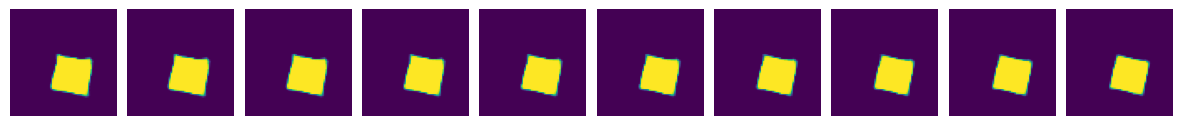

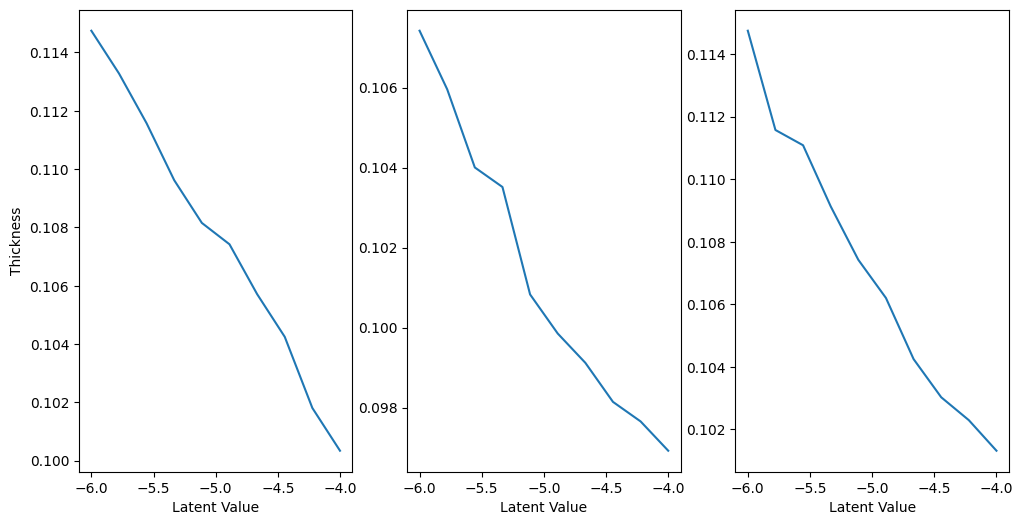

In [34]:
model=get_model(8)
lower_bound,upper_bound=-6,-4
code_sample_size=10
traversals= torch.linspace(start = lower_bound, end=upper_bound, steps=code_sample_size)
data1 = ds_ref.__getitem__(49847)[0]
data2 = ds_ref.__getitem__(245760)[0]
data3 = ds_ref.__getitem__(491520)[0]
datas=[data1,data2,data3]
sizes=[]
for data in datas:
    images = traverse_latent(data, device, model, 7, code_sample_size,lower_bound,upper_bound,n_cols=code_sample_size,plot=True)
    _,surfaces=get_surface_mov(images)
    sizes.append(surfaces)
fig,ax=plt.subplots(1,3,figsize=(12,6))
ax[0].plot(traversals,[i for i in sizes[0]])
ax[0].set_xlabel("Latent Value");
ax[0].set_ylabel("Thickness");
ax[1].plot(traversals,[i for i in sizes[1]]);
ax[1].set_xlabel("Latent Value");
ax[2].plot(traversals,[i for i in sizes[2]]);
ax[2].set_xlabel("Latent Value");


plt.savefig("extrapolating_dspr.png")